Libraries

In [53]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

Checking device (GPU or CPU)

In [54]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

Using device: cpu


Load the dataset

In [55]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(r"D:\cell_images", transform=transform)
classes = dataset.classes
print("Classes: ", classes)

Classes:  ['Parasitized', 'Uninfected']


In [56]:
train = int(0.01 * len(dataset))
val = int(0.002 * len(dataset))
test = int(0.002 * len(dataset)) 
extra = len(dataset) - (train + val + test)

trainDataset, valDataset, testDataset, _ = random_split(dataset, [train, val, test, extra])

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=256, shuffle=False)

print(f"Dataset Split:- Train: {len(trainDataset)}, Validate: {len(valDataset)}, Test: {len(testDataset)}")

Dataset Split:- Train: 275, Validate: 55, Test: 55


Visualizing the Image

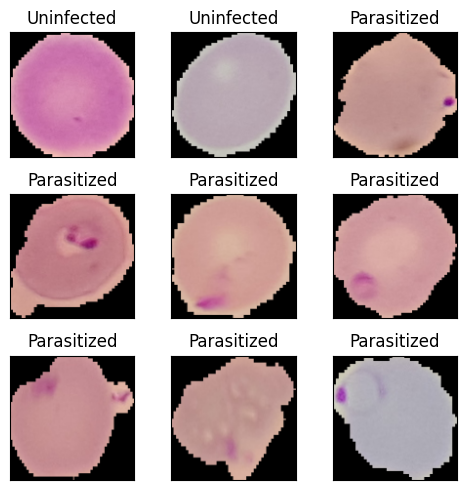

In [57]:
images, labels = next(iter(trainLoader))
plt.figure(figsize=(5,5))

for i in range(9):
    img = images[i].permute(1,2,0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    plt.subplot(3, 3, i+1, xticks=[], yticks=[])
    plt.imshow(img)
    plt.title(classes[labels[i]])

plt.tight_layout()
plt.show()

Defining CNN model

In [ ]:
class simpleCNN(nn.Module):
    def __init__(self, numClasses=2):
        super(simpleCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LayerNorm([32,64,64]),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128*8*8, numClasses)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
        
    def forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flatten(x)
        return x

Defining Deep CNN model

In [59]:
class DeepCNN(nn.Module):
    def __init__(self, numClasses=2):
        super(DeepCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.LayerNorm([64,64,64]),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.GroupNorm(16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.MaxPool2d(2,2)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, numClasses)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def forward_features(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

VGG Normalization Model

In [60]:
class VGGNormMix(nn.Module):
    def __init__(self, numClasses=2):
        super(VGGNormMix, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.LayerNorm([128,64,64]),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.GroupNorm(16,128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1),
            nn.GroupNorm(32,256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4)
        )

        self.flatten = nn.Flatten()
        # After 3 maxpools from 128x128 => output feature map 16x16
        self.fc = nn.Linear(256*16*16, numClasses)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        return self.fc(x)

    def forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        return x

Training Setup

In [61]:
def train_one(model, trainLoader, valLoader, epochs=25):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in trainLoader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()         # reset gradients
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()               # backpropagation
            optimizer.step()              # update weights
            total_loss += loss.item()

        # Validation accuracy after each epoch
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in valLoader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, pred = torch.max(outputs, 1)
                total += y.size(0)
                correct += (pred == y).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}  Loss={total_loss:.3f}  Val={val_acc:.2f}%")

        if val_acc > best_val:
            best_val = val_acc
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model, best_val

Testing the model

In [62]:
def evaluate(model, testLoader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true.append(y.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    return 100 * correct / total, np.concatenate(y_true), np.concatenate(y_pred)

Training all the models

In [63]:
ALL_MODELS = {
    "simpleCNN": simpleCNN(numClasses=len(classes)),
    "DeepCNN": DeepCNN(numClasses=len(classes)),
    "VGGNormMix": VGGNormMix(numClasses=len(classes))
}


Training simpleCNN
Epoch 1/25  Loss=6.630  Val=52.73%
Epoch 2/25  Loss=6.031  Val=47.27%
Epoch 3/25  Loss=5.852  Val=47.27%
Epoch 4/25  Loss=3.303  Val=52.73%
Epoch 5/25  Loss=1.882  Val=52.73%
Epoch 6/25  Loss=2.565  Val=52.73%
Epoch 7/25  Loss=1.538  Val=47.27%
Epoch 8/25  Loss=2.319  Val=43.64%
Epoch 9/25  Loss=1.472  Val=52.73%
Epoch 10/25  Loss=2.161  Val=52.73%
Epoch 11/25  Loss=1.675  Val=50.91%
Epoch 12/25  Loss=1.393  Val=47.27%
Epoch 13/25  Loss=1.828  Val=49.09%
Epoch 14/25  Loss=1.401  Val=52.73%
Epoch 15/25  Loss=1.368  Val=52.73%
Epoch 16/25  Loss=1.340  Val=49.09%
Epoch 17/25  Loss=1.444  Val=52.73%
Epoch 18/25  Loss=1.312  Val=52.73%
Epoch 19/25  Loss=1.244  Val=54.55%
Epoch 20/25  Loss=1.278  Val=54.55%
Epoch 21/25  Loss=1.157  Val=54.55%
Epoch 22/25  Loss=1.207  Val=56.36%
Epoch 23/25  Loss=1.221  Val=56.36%
Epoch 24/25  Loss=1.297  Val=56.36%
Epoch 25/25  Loss=1.165  Val=61.82%


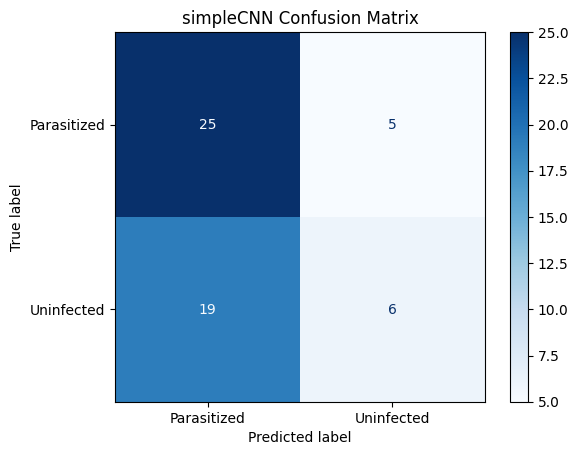


Training DeepCNN
Epoch 1/25  Loss=16.661  Val=47.27%
Epoch 2/25  Loss=9.059  Val=52.73%
Epoch 3/25  Loss=6.124  Val=47.27%
Epoch 4/25  Loss=4.621  Val=52.73%
Epoch 5/25  Loss=6.076  Val=47.27%
Epoch 6/25  Loss=5.901  Val=47.27%
Epoch 7/25  Loss=3.073  Val=52.73%
Epoch 8/25  Loss=4.569  Val=52.73%
Epoch 9/25  Loss=3.273  Val=43.64%
Epoch 10/25  Loss=3.056  Val=47.27%
Epoch 11/25  Loss=2.936  Val=43.64%
Epoch 12/25  Loss=1.736  Val=52.73%
Epoch 13/25  Loss=2.433  Val=52.73%
Epoch 14/25  Loss=1.761  Val=47.27%
Epoch 15/25  Loss=1.834  Val=54.55%
Epoch 16/25  Loss=1.416  Val=52.73%
Epoch 17/25  Loss=1.700  Val=54.55%
Epoch 18/25  Loss=1.439  Val=50.91%
Epoch 19/25  Loss=1.494  Val=50.91%
Epoch 20/25  Loss=1.415  Val=54.55%
Epoch 21/25  Loss=1.413  Val=50.91%
Epoch 22/25  Loss=1.355  Val=52.73%
Epoch 23/25  Loss=1.498  Val=52.73%
Epoch 24/25  Loss=1.448  Val=52.73%
Epoch 25/25  Loss=1.331  Val=50.91%


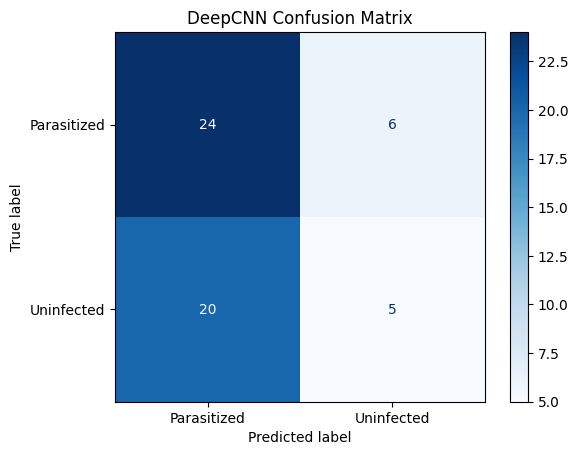


Training VGGNormMix
Epoch 1/25  Loss=22.226  Val=52.73%
Epoch 2/25  Loss=28.717  Val=47.27%
Epoch 3/25  Loss=17.020  Val=47.27%
Epoch 4/25  Loss=10.097  Val=52.73%
Epoch 5/25  Loss=12.731  Val=47.27%
Epoch 6/25  Loss=9.016  Val=47.27%
Epoch 7/25  Loss=4.543  Val=56.36%
Epoch 8/25  Loss=4.271  Val=50.91%
Epoch 9/25  Loss=2.191  Val=47.27%
Epoch 10/25  Loss=2.506  Val=49.09%
Epoch 11/25  Loss=1.721  Val=50.91%
Epoch 12/25  Loss=2.018  Val=50.91%
Epoch 13/25  Loss=1.531  Val=47.27%
Epoch 14/25  Loss=1.823  Val=50.91%
Epoch 15/25  Loss=1.589  Val=45.45%
Epoch 16/25  Loss=2.424  Val=52.73%
Epoch 17/25  Loss=1.902  Val=52.73%
Epoch 18/25  Loss=1.870  Val=49.09%
Epoch 19/25  Loss=1.334  Val=47.27%
Epoch 20/25  Loss=1.363  Val=47.27%
Epoch 21/25  Loss=1.873  Val=47.27%
Epoch 22/25  Loss=1.516  Val=49.09%
Epoch 23/25  Loss=1.515  Val=47.27%
Epoch 24/25  Loss=1.224  Val=49.09%
Epoch 25/25  Loss=1.559  Val=54.55%


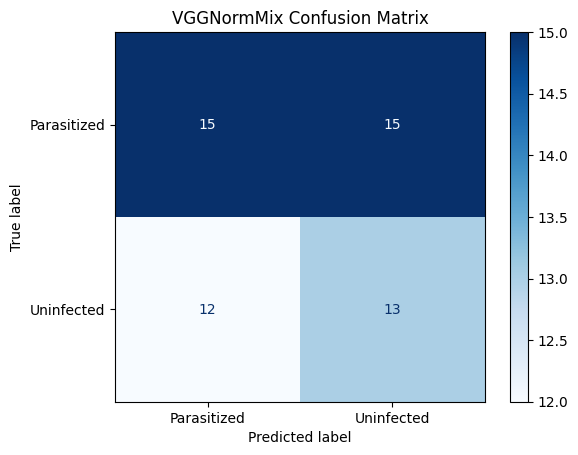

In [64]:
results = {}

for name, model_obj in ALL_MODELS.items():
    print(f"\nTraining {name}")
    trained_model, best_val = train_one(model_obj, trainLoader, valLoader, epochs=25)

    test_acc, y_true, y_pred = evaluate(trained_model, testLoader)

    results[name] = {
        "model": trained_model,
        "ValAcc": best_val,
        "TestAcc": test_acc
    }

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

Table and Best Model

In [65]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = "Model"
results_df = results_df[["ValAcc", "TestAcc"]].round(2)
print("\nFinal Accuracy Table:\n", results_df)


Final Accuracy Table:
             ValAcc  TestAcc
Model                      
simpleCNN    61.82    56.36
DeepCNN      54.55    52.73
VGGNormMix   56.36    50.91


Bar Plot

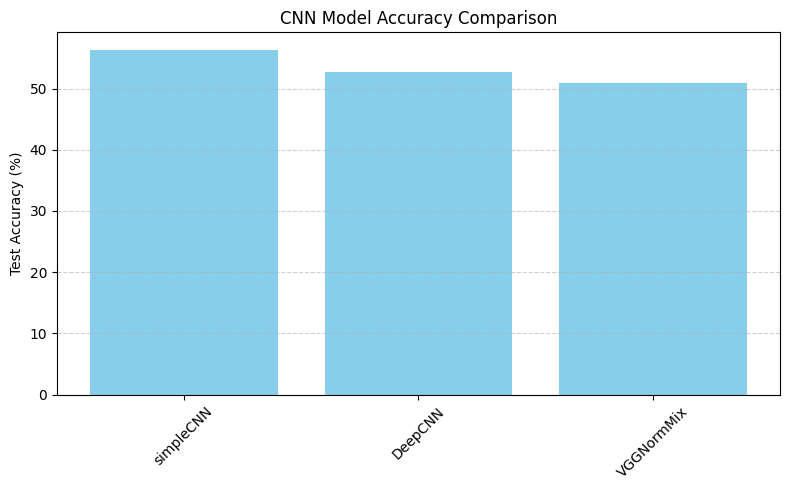

In [66]:
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df["TestAcc"], color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Test Accuracy (%)")
plt.title("CNN Model Accuracy Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Extracting Features for Classifiers

In [67]:
def extractFeatures(model, dataLoader):
    model.eval()
    features, labelsList = [], []
    with torch.no_grad():
        for images, labels in dataLoader:
            images = images.to(device)
            x = model.forward_features(images)
            features.append(x.cpu().numpy())
            labelsList.append(labels.numpy())
    
    return np.concatenate(features), np.concatenate(labelsList)

In [68]:
print("Extracting features from CNN...")
best_model = results[best_model_name]["model"].to(device)
trainFeatures, trainLabels = extractFeatures(best_model, trainLoader)
testFeatures, testLabels = extractFeatures(best_model, testLoader)

Extracting features from CNN...


Classical ML Classifiers

In [69]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}


Training Logistic Regression
Logistic Regression Accuracy: 80.00%


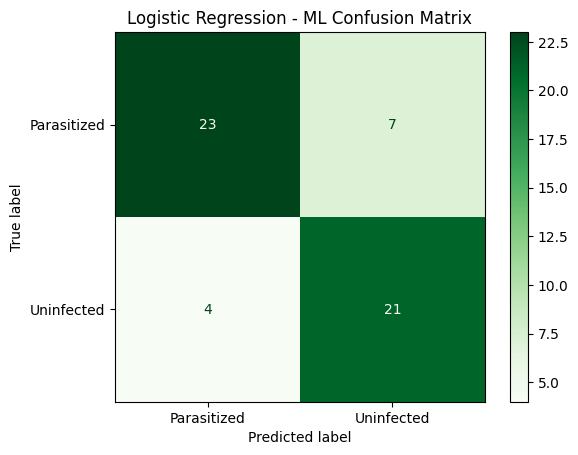


Training SVM
SVM Accuracy: 76.36%


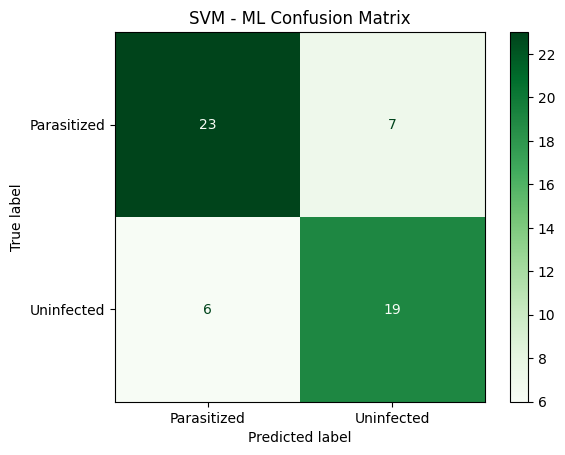


Training Random Forest
Random Forest Accuracy: 74.55%


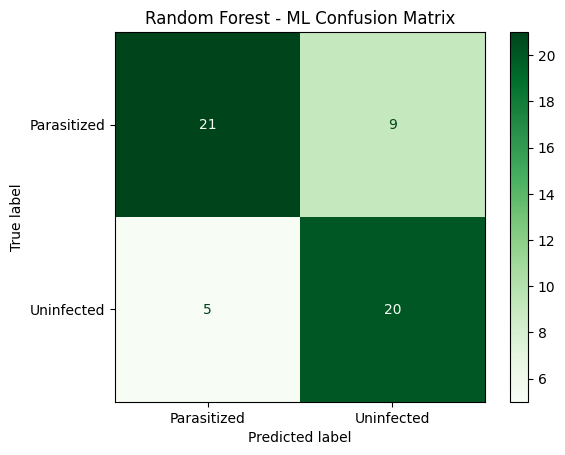


Training Decision Tree
Decision Tree Accuracy: 56.36%


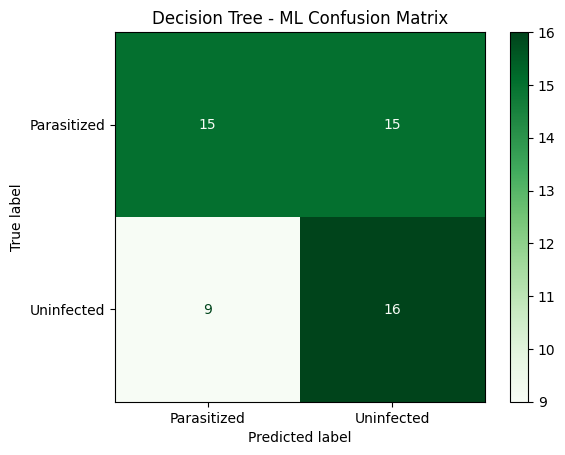


Training KNN
KNN Accuracy: 58.18%


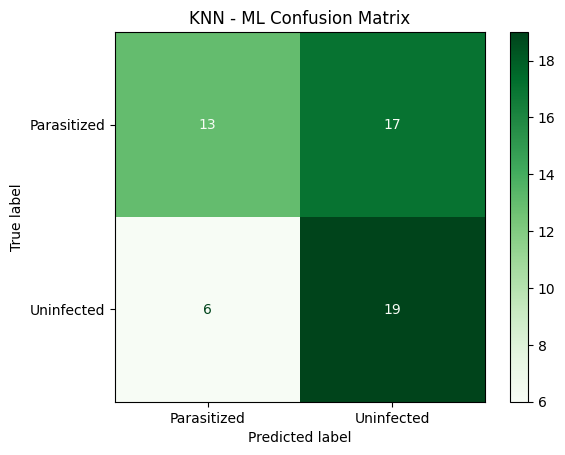


Training Naive Bayes
Naive Bayes Accuracy: 69.09%


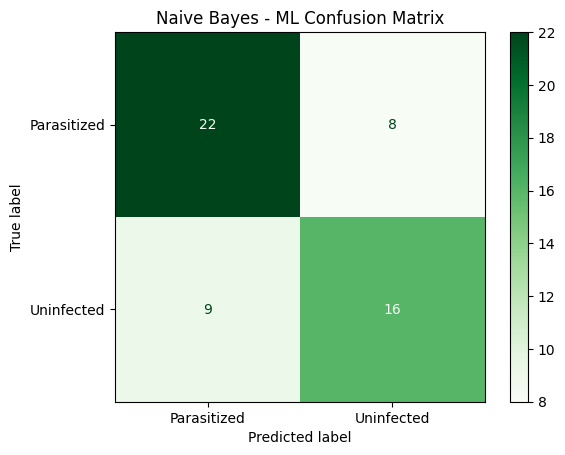

In [70]:
results = {}
for name, clf in classifiers.items():
    print(f"\nTraining {name}")

    clf.fit(trainFeatures, trainLabels)
    preds = clf.predict(testFeatures)
    acc = accuracy_score(testLabels, preds) * 100
    results[name] = acc

    print(f"{name} Accuracy: {acc:.2f}%")

    cm = confusion_matrix(testLabels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Greens", values_format='d')
    plt.title(f"{name} - ML Confusion Matrix")
    plt.show()

In [71]:
ml_df = pd.DataFrame(results, index=["Accuracy (%)"]).T
ml_df = ml_df.sort_values(by="Accuracy (%)", ascending=False)

print("\nClassical ML Results (Descending Order):\n", ml_df)


Classical ML Results (Descending Order):
                      Accuracy (%)
Logistic Regression     80.000000
SVM                     76.363636
Random Forest           74.545455
Naive Bayes             69.090909
KNN                     58.181818
Decision Tree           56.363636


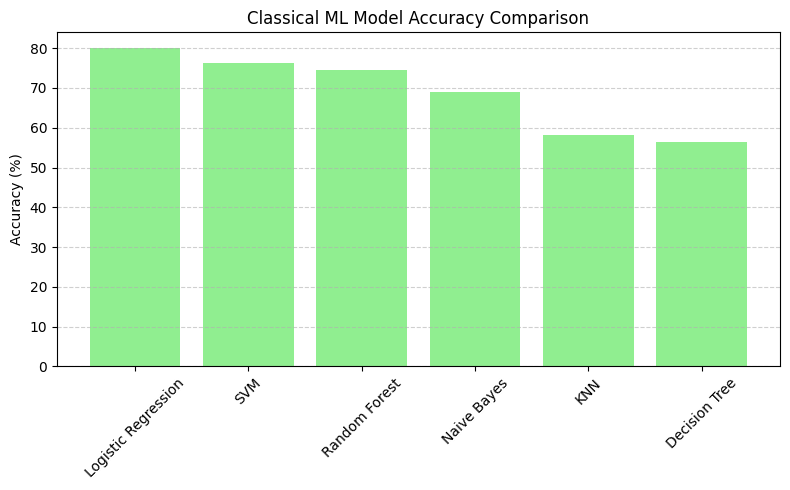

In [72]:
plt.figure(figsize=(8,5))
plt.bar(ml_df.index, ml_df["Accuracy (%)"], color="lightgreen")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Classical ML Model Accuracy Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()